In [1]:
import numpy as np
import cv2
from pprint import pprint
import ffmpeg
import sys
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [2]:
filename = "/home/dmitry/work/open_source_stuff/blitz_DS/replay_videos/test.mp4" #5396 frames 4 minutes 0 seconds

In [3]:
def count_frames(filename):
    counter = 0
    cap = cv2.VideoCapture(filename)
    ret = 1
    while(ret):
        ret, _ = cap.read()
        counter += 1
    counter -= 1 #the last cycle passed with no frame
    cap.release()
    return counter

def get_nbframes(filename):
    return int(ffmpeg.probe(filename)['streams'][1]['nb_frames'])

def get_frame(filename, n_frame):
    cap = cv2.VideoCapture(filename)
    for i in range(n_frame - 1):
        cap.read()
    _, frame = cap.read()
    return frame

def show_frame(frame, time = 5000):
    cv2.imshow("frame", frame)
    cv2.waitKey(time)
    cv2.destroyAllWindows()
    
def get_similarity(filename):
    bins = 60
    histSize = [bins]
    ranges = [0, 255]

    reference = cv2.imread("test_frame.png")[0:272, 276:552]
    ref_hsv = cv2.cvtColor(reference, cv2.COLOR_BGR2HSV)
    ref_hue_hist = cv2.calcHist(ref_hsv, [0], None, histSize, ranges)

    hue_similarities = []
    cap = cv2.VideoCapture(filename)
    for i in range(get_nbframes(filename)):
        #print(i, end = None)
        _, frame = cap.read()
        ROI = frame[0:272, 276:552]
        ROI_hsv = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
        hue_hist = cv2.calcHist(ROI_hsv, [0], None, histSize, ranges)
        hue_similarity = cv2.compareHist(hue_hist, ref_hue_hist, method = 0)

        hue_similarities.append(hue_similarity)
        #clear_output(wait = True)
    cap.release()
    return hue_similarities

def find_battle_start(filename, threshold = 0.2):
    bins = 60
    histSize = [bins]
    ranges = [0, 255]

    reference = cv2.imread("test_frame.png")[0:272, 276:552]
    ref_hsv = cv2.cvtColor(reference, cv2.COLOR_BGR2HSV)
    ref_hue_hist = cv2.calcHist(ref_hsv, [0], None, histSize, ranges)

    hue_similarities = []
    cap = cv2.VideoCapture(filename)
    status = True
    similarity = 0
    
    counter = 0
    while(status and similarity < 0.2):
        counter += 1
        status, frame = cap.read()
        ROI = frame[0:272, 276:552]
        ROI_hsv = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
        hue_hist = cv2.calcHist(ROI_hsv, [0], None, histSize, ranges)
        similarity = cv2.compareHist(hue_hist, ref_hue_hist, method = 0)
    print("Battle start frame: ", counter)
    return cap

def cut_first_minute(filename):
    cap = find_battle_start(filename)
    n_frames = 60 * 23
    sequence = np.zeros((272, 552 - 276, 3, n_frames), dtype = np.uint8)
    for i in range(60 * 23):
        _, frame = cap.read()
        sequence[:,:,:,i] = frame[0:272, 276:552, :]
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    return sequence

def play_sequence(seq):
    n_frames = seq.shape[-1]
    for i in range(n_frames):
        cv2.imshow("sequence", seq[:,:,:,i])
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    return 0

In [17]:
seq = cut_first_minute(filename)

Battle start frame:  305


In [16]:
play_sequence(seq)

0

In [36]:
test_frame = seq[:,:,:,500].copy()

In [109]:
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

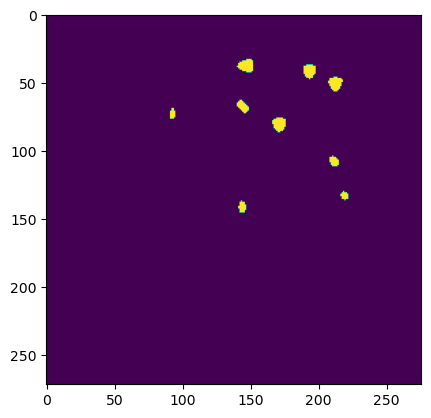

In [69]:
plt.imshow(gaussian_filter((test_frame[:,:,1] > 180).astype(float), sigma = 3) > 0.5)
plt.show()

In [96]:
conditioned = gaussian_filter((test_frame[:,:,1] > 180).astype(float), sigma = 3) > 0.5

In [90]:
test = np.ones_like(conditioned)

In [97]:
for x in range(250):
    for y in range(250):
        if x > y - 30:
            conditioned[x, y] = 0

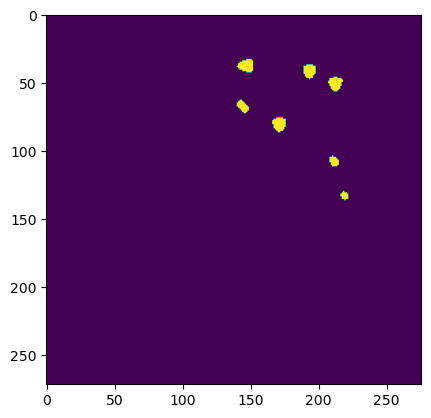

In [98]:
plt.imshow(conditioned)
plt.show()

In [103]:
coords_T = np.where(conditioned > 0)

In [130]:
conditioned.dtype

dtype('bool')

In [110]:
coords = np.transpose(coords_T)

In [111]:
k_means = KMeans(init='k-means++', n_clusters=7, n_init=10)
k_means.fit(coords)
k_means_labels = k_means.labels_

In [119]:
k_means_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [133]:
result = np.zeros_like(conditioned, dtype = float)
for i, coord in enumerate(coords):
    #print(coord)
    result[coord[0], coord[1]] = k_means_labels[i] + 1

In [128]:
result[coord[0], coord[1]]

6.0

In [ ]:
result

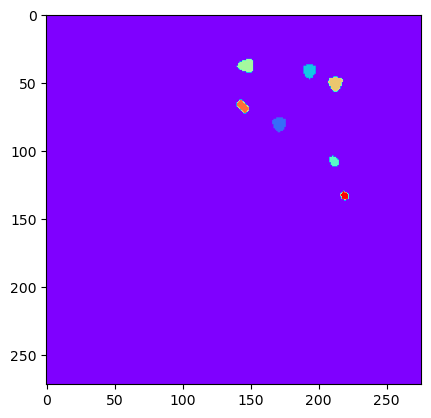

In [134]:
plt.imshow(result, cmap = 'rainbow')
plt.show()

In [ ]:
coords = np.transpose(coords_T)